In [1]:
import pandas as pd
import numpy as np
import os
from Bio import SeqIO
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
#Calculate the pooled variance, given sample sizes and standard deviations of each group
def get_std(participant_average_list,participant_samplesn_list,participant_sd_list):
    pooled_variance_numerator = 0
    pooled_variance_denominator = 0
    counter = 0
    for n in participant_samplesn_list:
        pooled_variance_numerator = pooled_variance_numerator + (n - 1)*participant_sd_list[counter]**2
        pooled_variance_denominator = pooled_variance_denominator + n
        counter = counter + 1

    pooled_variance_denominator = pooled_variance_denominator - len(participant_samplesn_list)

    #If samples sizes of all participants are 1, just calculate standard deviation
    if pooled_variance_denominator == 0:
        return(np.std(participant_average_list))
    
    #If pooled variance method is appropriate, calculate pooled variance and take square root to report
    #standard deviation
    else:
        pooled_variance = pooled_variance_numerator/pooled_variance_denominator
        return(np.sqrt(pooled_variance))
    
# #Return average length of seqs in EC
# def get_avelen_ec(EC_query):
#     ec_orfs_recs = SeqIO.parse('/home/ec2-user/20210602_metasecretome_figures/ipynb_out/EC_orfids/' + EC_query, 'fasta')

#     len_list = [len(str(rec.seq)) for rec in ec_orfs_recs]
#     return(np.average(len_list)/1000)

# #Why do we have to do this, when we have lists of orfs for each EC?

#Return average nucleotide length of seqs in EC (secreted ORFs only)
def get_avelen_ec(EC_query):
    #EC_query = '3.5.1.28'
    ec_orfs_list = []
    
    for name, group in eggnog_output_filtered.groupby('EC'):
        if EC_query in name.split(','):
            ec_orfs_list = ec_orfs_list + group['query_name'].tolist()

    input_seq_iterator = SeqIO.parse('/home/ec2-user/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/ipynb_out/rep_mag_hgm_metasecretome.fna', 'fasta')
    #secreted_orfids = list(group['orfid'])
    secrecs = [len(str(record.seq)) for record in input_seq_iterator if record.id in ec_orfs_list]
    return(np.average(secrecs)/1000)

#Average over samples from same individual, then over the same GI subloc, etc
def average_samples(xpkm_df):
    norm_sec_ave_df = pd.DataFrame()
    norm_sec_std_df = pd.DataFrame()

    for EC in xpkm_df.index.tolist():
        #Store averages and standard deviations of each EC
        subloc_readcount_list = []
        subloc_readcount_aves = []
        subloc_readcount_stds = []
        #Compute for each GI sublocation within the EC
        for subloc in gi_prox2dist:
            runs = meta[meta['tissue_type'] == subloc]['Run'].unique().tolist()
            runsin = set(xpkm_df.columns) & set(runs)
            subloc_sel = xpkm_df[runsin].loc[EC]
            subloc_readcount_list.append(subloc_sel)

            #Average samples from same person first and calculate standard deviation
            grouped_runs = meta[meta['Run'].isin(set(xpkm_df.columns) & set(runs))].groupby('Participant')
            participant_average_list = []
            participant_sd_list = []
            participant_samplesn_list = []
            for name, group in grouped_runs:
                participant_average = np.average(subloc_sel[group['Run'].unique()])
                participant_average_list.append(participant_average)
                participant_sd = np.std(subloc_sel[group['Run'].unique()])
                participant_sd_list.append(participant_sd)
                participant_samplesn_list.append(group['Run'].unique().shape[0])

            #Average the samples for site from the same EC
            subloc_readcount_aves.append(np.average(participant_average_list))
            #subloc_readcount_stds.append(np.sqrt(get_pooled_var(participant_samplesn_list,participant_sd_list)))
            subloc_readcount_stds.append(get_std(participant_average_list,participant_samplesn_list,participant_sd_list))

        norm_sec_std_df = norm_sec_std_df.append(pd.Series(subloc_readcount_aves,name=EC))
        norm_sec_ave_df = norm_sec_ave_df.append(pd.Series(subloc_readcount_aves, name=EC))

    norm_sec_ave_df.columns = gi_prox2dist
    norm_sec_std_df.columns = gi_prox2dist

    return(norm_sec_ave_df, norm_sec_std_df)

def get_reordered_indices(cg, old_indices_list):   
    #Get order of clustered ECs
    reordered_row_inds = cg.dendrogram_row.reordered_ind
    original_row_list = old_indices_list #e.g. sel_descriptions.index.tolist()
    reordered_row_list = []
    for row in reordered_row_inds:
        reordered_row_list.append(original_row_list[row])
    return(reordered_row_list)

In [ ]:
! aws s3 cp s3://florencia-velez/working/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_pwymjija_annotations.tsv /home/ec2-user/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_pwymjija_annotations.tsv
! aws s3 cp s3://florencia-velez/working/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_4fybgn2o_annotations.tsv /home/ec2-user/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_4fybgn2o_annotations.tsv
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv ipynb_out/HGM_master_sec_nonsec.tsv
! aws s3 cp s3://florencia-velez/working/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv /home/ec2-user/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/ave_rpkm_df_fig6_v5.tsv ipynb_out/ave_rpkm_df_fig6_v5.tsv
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/enzclass.txt ipynb_out/enzclass.txt
! aws s3 cp s3://florencia-velez/working/20210628_hmm_cazymes_HGM_repmags/20210628_hmmer_dbcan_parser.log /home/ec2-user/20210628_hmm_cazymes_HGM_repmags/20210628_hmmer_dbcan_parser.log
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/EC_names_raw.txt ipynb_out/EC_names_raw.txt
! aws s3 cp s3://florencia-velez/working/20201026_elinav_segal_2018_metagenomics/SraRunTable_PRJEB28097.txt /home/ec2-user/20201026_elinav_segal_2018_metagenomics/SraRunTable_PRJEB28097.txt
! aws s3 cp s3://florencia-velez/working/20210602_metasecretome_figures/ipynb_out/Figure5_v2_all_ec_readstats_df.tsv ipynb_out/Figure5_v2_all_ec_readstats_df.tsv

In [3]:
#Plot coverage as a heatmap 
#gi samples organized by proximal to distal 
#mags ... try to label by phylum
stomach_prox2dist = ['Gastric fundus mucosa',
                     'Stomach lumen',
                     'Gastric antrum mucosa']
small_int_prox2dist = ['Duodenal bulb mucosa',
                       'Duodenum lumen',
                        'Jejunum lumen',
                       'Jejunum mucosa',
                        'Terminal ileum lumen',
                       'Terminal ileum mucosa']
large_int_prox2dist = [ 'Cecum lumen',
                     'Cecum mucosa',
                       'Ascending colon mucosa',
                       'Transverse colon mucosa',
                       'Descending colon lumen',
                       'Descending colon mucosa',
                       'Sigmoid colon mucosa',
                       'Rectum mucosa']

gi_prox2dist = ['Gastric fundus mucosa',
                     'Stomach lumen',
                     'Gastric antrum mucosa',
                     'Duodenal bulb mucosa',
                       'Duodenum lumen',
                        'Jejunum lumen',
                       'Jejunum mucosa',
                        'Terminal ileum lumen',
                       'Terminal ileum mucosa',
                      'Cecum lumen',
                     'Cecum mucosa',
                       'Ascending colon mucosa',
                       'Transverse colon mucosa',
                       'Descending colon lumen',
                       'Descending colon mucosa',
                       'Sigmoid colon mucosa',
                       'Rectum mucosa',
                       'Stool']

mucosal_gi_sites = ['Gastric fundus mucosa',
                     
                     'Gastric antrum mucosa',
                     'Duodenal bulb mucosa',
                       
                     
                       'Jejunum mucosa',
                      
                       'Terminal ileum mucosa',
                      
                     'Cecum mucosa',
                       'Ascending colon mucosa',
                       'Transverse colon mucosa',
                    
                       'Descending colon mucosa',
                       'Sigmoid colon mucosa',
                       'Rectum mucosa',
                       'Stool']
lumen_gi_sites = ['Stomach lumen',
                     
                       'Duodenum lumen',
                        'Jejunum lumen',
                       
                        'Terminal ileum lumen',
                      
                      'Cecum lumen',
                  
                       'Descending colon lumen',
                     
                       'Stool']

col_dict = {'Ascending colon mucosa':'orange', 
 'Cecum lumen': 'cornflowerblue',
'Cecum mucosa': 'blue',
 'Descending colon lumen':'tomato',
'Descending colon mucosa':'red',
'Duodenal bulb mucosa':'teal',
'Duodenum lumen':'turquoise',
'Gastric antrum mucosa':'gray',
'Gastric fundus mucosa':'silver',
'Jejunum lumen':'violet',
'Jejunum mucosa':'magenta',
'Rectum mucosa': 'peru',
'Sigmoid colon mucosa':'chocolate', 
'Stomach lumen': 'gold',
'Terminal ileum lumen': 'limegreen',
'Terminal ileum mucosa': 'forestgreen',
'Transverse colon mucosa': 'sienna',
'Stool': 'black'}

gi_prox2dist_coor = {'Gastric fundus mucosa': 1.0,
 'Stomach lumen': 2.0,
 'Gastric antrum mucosa': 3.0,
 'Duodenal bulb mucosa':5.5,
 'Duodenum lumen':6.5,
 'Jejunum lumen':9.0,
 'Jejunum mucosa':10.0,
 'Terminal ileum lumen':12.5,
 'Terminal ileum mucosa':13.5,
 'Cecum lumen':16.0,
 'Cecum mucosa':17.0,
 'Ascending colon mucosa':19.5,
 'Transverse colon mucosa':22.0,
 'Descending colon lumen':24.5,
 'Descending colon mucosa':25.5,
 'Sigmoid colon mucosa':28.0,
 'Rectum mucosa':30.5,
 'Stool':33.0}

gi_prox2dist_coor_overlay = {'Gastric fundus mucosa': 0.5,
 'Stomach lumen': 2.0,
 'Gastric antrum mucosa': 3.0,
 'Duodenal bulb mucosa':5.5,
 'Duodenum lumen':6.5,
 'Jejunum lumen':9.0,
 'Jejunum mucosa':9.0,
 'Terminal ileum lumen':11.5,
 'Terminal ileum mucosa':11.5,
 'Cecum lumen':14.0,
 'Cecum mucosa':14.0,
 'Ascending colon mucosa':16.5,
 'Transverse colon mucosa':19.0,
 'Descending colon lumen':21.5,
 'Descending colon mucosa':21.5,
 'Sigmoid colon mucosa':24.0,
 'Rectum mucosa':26.5,
 'Stool':29.0}

#Color by GI sublocalization
#Import metadata
meta = pd.read_csv('~/20201026_elinav_segal_2018_metagenomics/SraRunTable_PRJEB28097.txt', sep=',')

In [4]:
eggnog_cols = ['query_name','seed_eggNOG_ortholog','seed_ortholog_evalue','seed_ortholog_score',
 'best_tax_level','Preferred_name','GOs','EC','KEGG_ko','KEGG_Pathway','KEGG_Module','KEGG_Reaction',
 'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG_Reaction','Domain','not_sure','not_sure1','COG_category','description']

eggnog_output = pd.read_csv('/home/ec2-user/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_pwymjija_annotations.tsv',
           skiprows=4, sep='\t', names=eggnog_cols, index_col=False, skipfooter=3)
eggnog_output = eggnog_output.append(pd.read_csv('/home/ec2-user/20210331_rep_HGM_gi_stool_subloc_metagenomic_bt2/20210407_eggnog/job_MM_4fybgn2o_annotations.tsv',
           skiprows=4, sep='\t', names=eggnog_cols, index_col=False, skipfooter=3))

HGM_master_sec_nonsec = pd.read_csv('ipynb_out/HGM_master_sec_nonsec.tsv', sep='\t')
HGM_master_sec_orfids = HGM_master_sec_nonsec[HGM_master_sec_nonsec['Secreted'] == 'Secreted']['orfid'].tolist()

#Filter eggNOG results for new representative, new secreted proteins #later make sure this is bacterial only
representative_hgm_mags = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv')
eggnog_output_filtered = eggnog_output[eggnog_output['query_name'].isin(representative_hgm_mags['orfid'].tolist())]
eggnog_output_filtered['genome_id'] = ['_'.join(orfid.split('_')[:2]) for orfid in eggnog_output_filtered['query_name']]
eggnog_output_filtered = eggnog_output_filtered[eggnog_output_filtered['query_name'].isin(HGM_master_sec_orfids)]

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
enzclass = pd.read_csv('ipynb_out/enzclass.txt', sep='\t', header=None, names=['EC_number','EC_description'])
enzclass['EC_number'] = [ec.replace(' ','').replace('.-','') for ec in enzclass['EC_number']]
enzclass['EC_description'] = [desc[0:-1] for desc in  enzclass['EC_description']]
enzclass_dict = enzclass.set_index('EC_number').to_dict()['EC_description']

third_level_ec_dict = dict()
for EC_cat in enzclass_dict.keys():
    if len(EC_cat.split('.')) > 2:
        first_level_ec_desc = enzclass_dict[EC_cat.split('.')[0]]
        second_level_ec_desc = enzclass_dict['.'.join(EC_cat.split('.')[:2])]
        third_level_ec_desc = enzclass_dict[EC_cat]
        full_description = first_level_ec_desc + " " + second_level_ec_desc[0].lower() + second_level_ec_desc[1:] + \
              " " + third_level_ec_desc[0].lower() + third_level_ec_desc[1:]
        third_level_ec_dict[EC_cat] = full_description

In [33]:
#Wrote EC descriptor file

#! awk '{if($1=="ID" || $1=="DE") print $0}' enzyme.dat > ipynb_out/EC_names_raw.txt

with open("ipynb_out/EC_names_raw.txt", "r", encoding='utf-8') as ecraw:
    ecrawlines = ecraw.read().splitlines()

EC2desc_dict = dict()
EC = 0
desc = 0
lastline = 0
for line in ecrawlines:
    if line.split('  ')[0] == 'ID':
        EC = line.replace('ID   ', '')
    else:
        if lastline.split('  ')[0] == 'DE':
            desc = desc + line.replace('DE   ', '')
            EC2desc_dict[EC] = desc[:-1]
        else:
            desc = line.replace('DE   ', '')
            EC2desc_dict[EC] = desc[:-1]
    
    lastline = line          

In [8]:
ave_rpkm_df = pd.read_csv('ipynb_out/ave_rpkm_df_fig6_v5.tsv', sep='\t', index_col=0)

In [37]:
os.mkdir('ipynb_out/Figures_eps/')

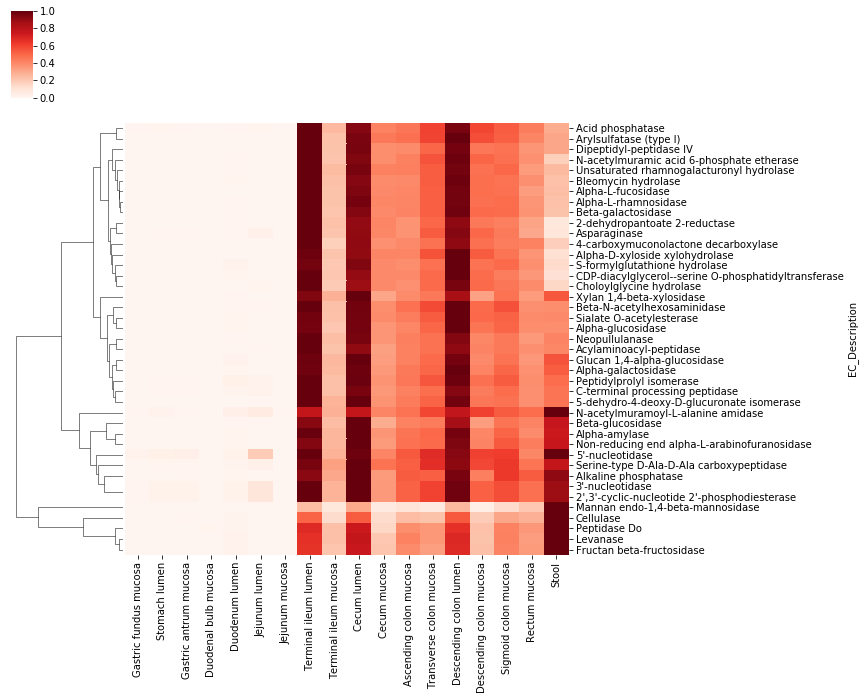

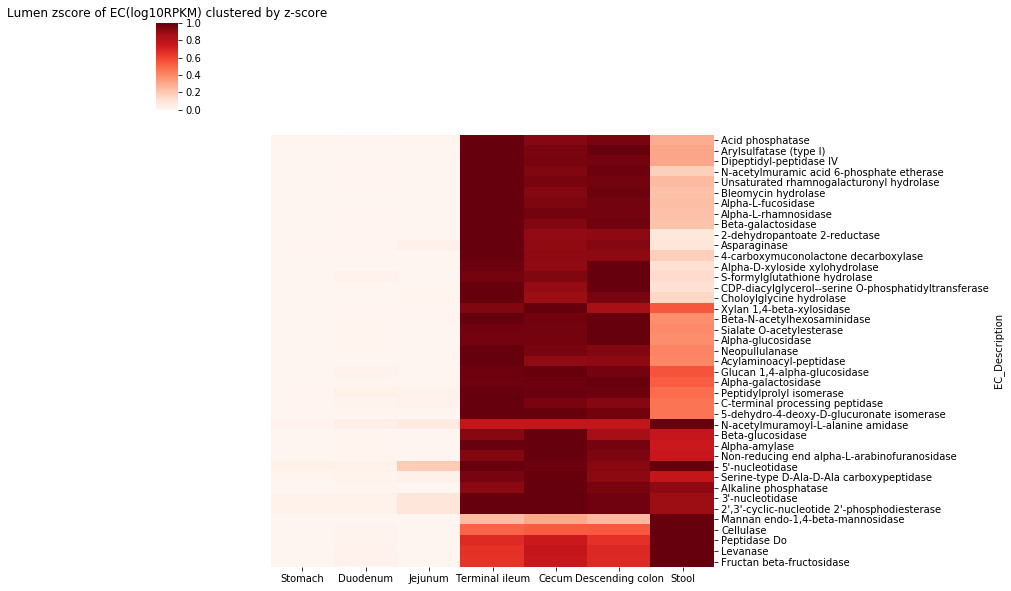

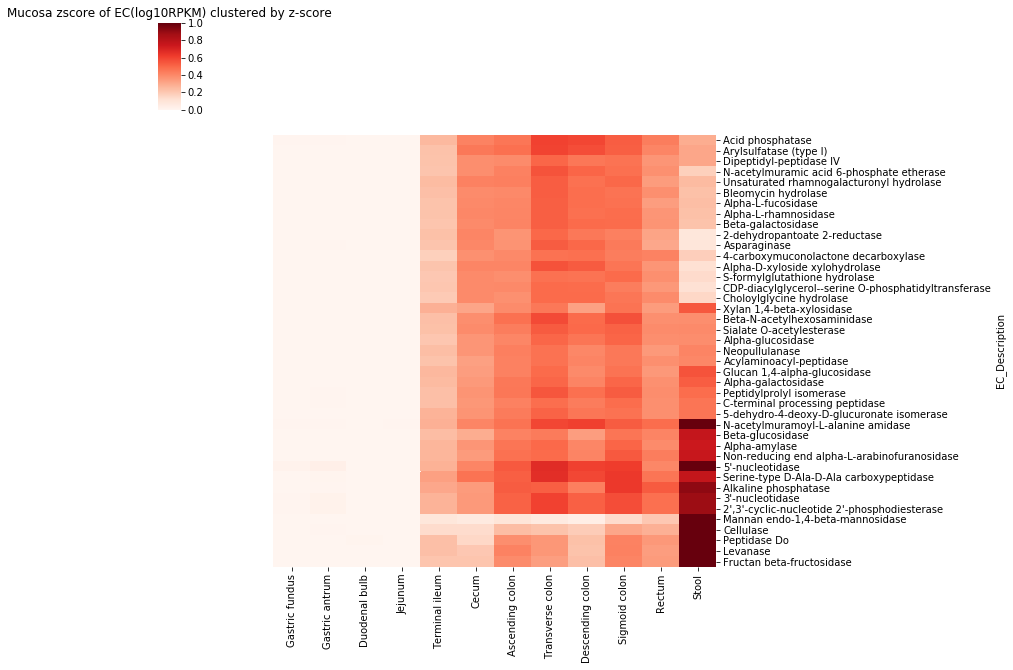

In [38]:
#Plot zscores of ECs
figsize = (10,10)
#Cluster based on zscores of both mucosa and lumen sites
#Minimum rpkm of 50 for highest GI subloc to keep EC in our list 
highest_ecs = ave_rpkm_df[np.max(ave_rpkm_df, axis=1) > 50].index.tolist()
highest_ecs_df = ave_rpkm_df.loc[highest_ecs]
zscore_ec_df = highest_ecs_df.div(np.max(highest_ecs_df, axis=1), axis="rows").dropna(how='all', axis=0)
#zscore_ec_df = ave_rpkm_df.div(np.max(ave_rpkm_df, axis=1), axis="rows").dropna(how='all', axis=0)

sel = zscore_ec_df#[mucosal_gi_sites]

max_val = 1.0 #np.max(np.max(np.log10(ave_rpkm_df.loc[highest_ecs])))

#sel = np.log10(ave_rpkm_df.loc[highest_ecs]).replace([np.inf, -np.inf], np.nan).fillna(0)
sel_descriptions = sel.join(pd.DataFrame(pd.Series(EC2desc_dict, name='EC_Description'))).set_index('EC_Description')
cg = sns.clustermap(sel_descriptions, vmin=0,vmax=max_val, col_cluster=False,figsize=figsize, cbar_kws={'label':''},
                    row_cluster=True,
                    cmap="Reds", yticklabels=1)

plt.rcParams['svg.fonttype'] = 'none'
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_clustermap_dendrogram_desc.svg',format='svg', bbox_inches="tight")
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_clustermap_dendrogram_desc.png',format='png', bbox_inches="tight")

reordered_row_list = get_reordered_indices(cg, sel_descriptions.index.tolist())

sel = zscore_ec_df[lumen_gi_sites]
sel_descriptions = sel.join(pd.DataFrame(pd.Series(EC2desc_dict, name='EC_Description'))).set_index('EC_Description')
sel_descriptions.columns = [site.replace(' lumen','').replace(' mucosa','') for site in sel_descriptions.columns.tolist()]
cg = sns.clustermap(sel_descriptions.loc[reordered_row_list], vmin=0,vmax=max_val, col_cluster=False,figsize=figsize, cbar_kws={'label':''},
                    row_cluster=False,
                    cmap="Reds", yticklabels=1)

plt.title('Lumen zscore of EC(log10RPKM) clustered by z-score')

plt.rcParams['svg.fonttype'] = 'none'
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_lum_clustermap_desc.svg',format='svg', bbox_inches="tight")
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_lum_clustermap_desc.png',format='png', bbox_inches="tight")

sel = zscore_ec_df[mucosal_gi_sites]
sel_descriptions = sel.join(pd.DataFrame(pd.Series(EC2desc_dict, name='EC_Description'))).set_index('EC_Description')
sel_descriptions.columns = [site.replace(' lumen','').replace(' mucosa','') for site in sel_descriptions.columns.tolist()]
cg = sns.clustermap(sel_descriptions.loc[reordered_row_list], vmin=0, vmax=max_val, col_cluster=False,figsize=figsize, cbar_kws={'label':''},
                    row_cluster=False,
                    cmap="Reds", yticklabels=1)
plt.title('Mucosa zscore of EC(log10RPKM) clustered by z-score')

plt.rcParams['svg.fonttype'] = 'none'
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_muc_clustermap_desc.svg',format='svg', bbox_inches="tight")
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_4thlevel_ecreads_zscoreec_muc_clustermap_desc.png',format='png', bbox_inches="tight")

plt.show()

In [27]:
#Plot ratio of mucosa to lumen
sitepairs = [('Gastric fundus mucosa', 'Stomach lumen'),
 ('Gastric antrum mucosa', 'Stomach lumen'),
            ('Duodenal bulb mucosa','Duodenum lumen'),
            ('Jejunum mucosa', 'Jejunum lumen'),
 ('Terminal ileum mucosa', 'Terminal ileum lumen'),
( 'Cecum mucosa', 'Cecum lumen'),
 ('Descending colon mucosa', 'Descending colon lumen')]#,


muc2lum_rpkm_ratio = pd.DataFrame()

for muc, lum in sitepairs:
    ratio = pd.Series(np.divide(highest_ecs_df[muc], highest_ecs_df[lum].replace(0,1)), name=muc.replace(' mucosa',''))
    muc2lum_rpkm_ratio = muc2lum_rpkm_ratio.append(ratio)

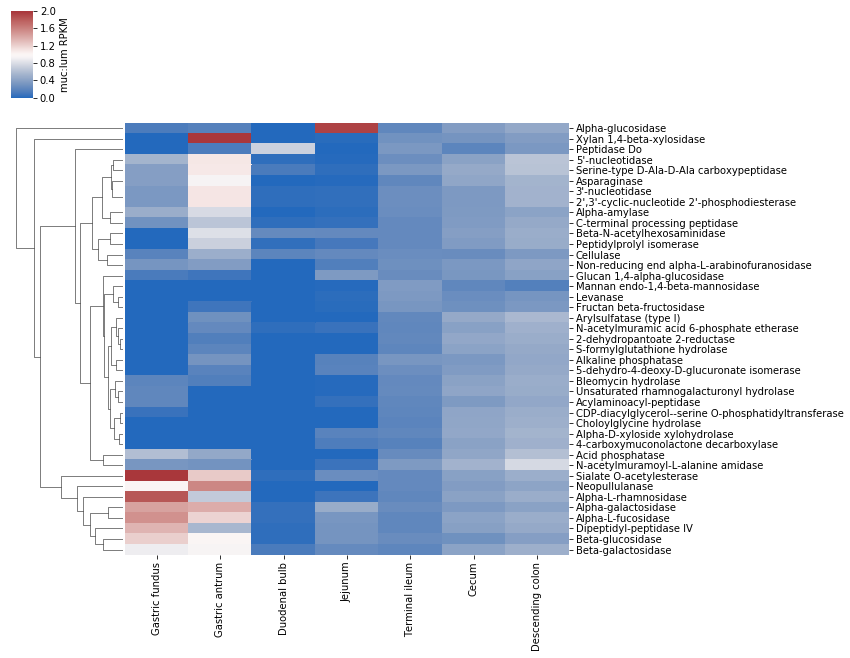

In [39]:
plt.rcParams.update({'font.size': 10})
figsize = (10,10)
#Plot top RPKM values 
#Remove ECs with very low reads mapping
#nonzeroECs = ave_rpkm_df[ave_rpkm_df > 10].dropna(how='all').index.tolist()

sel = muc2lum_rpkm_ratio.transpose().join(pd.Series(EC2desc_dict, name='')).set_index('')
cg = sns.clustermap(sel, vmin=0, col_cluster=False,figsize=figsize, cbar_kws={'label':'muc:lum RPKM'},
                   #dendrogram_ratio=0.1, cbar_pos=(-0.1, 0.82, 0.05, 0.08),
                   vmax=2, cmap = "vlag", yticklabels=1)

plt.rcParams['svg.fonttype'] = 'none'
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_muclumratio_clustermap_ecdesc.svg',format='svg', bbox_inches="tight")
cg.savefig('ipynb_out/Figures_eps/Fig6_v8_muclumratio_clustermap_ecdesc.png',format='png', bbox_inches="tight")

plt.show()